## Лабораторная работа №2
### Выполнила Рогозян Анастасия 19ПМИ-1

Сначала мы загрузим все нужные нам библиотеки и откроем файл с нашими данными из json

In [1]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install stop_words

Note: you may need to restart the kernel to use updated packages.


In [59]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import re
import string
import pymorphy2
import stop_words
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem.snowball import RussianStemmer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [60]:
from yellowbrick.classifier import ClassPredictionError

In [4]:
article_filename = "corpus.json" 
categories = ['Интересное', 'Индустрия','Кино','Техника','Скриншоты','Видео','Обновления']

In [5]:
news = []
with open(article_filename, encoding="utf-8") as file:
    for line in file:
        news.append(json.loads(line))
data = pd.DataFrame(news)
data

,link,title,tags,text,category
0,https://gamemag.ru//news/175225/the-pathless-c...,The Pathless от создателей ABZÛ через неделю в...,"[Индустрия, Annapurna Interactive, Giant Squid...",Annapurna Interactive выпустит приключенческу...,Индустрия
1,https://gamemag.ru//news/175219/redfall-and-ho...,Соразработчик Redfall и Hogwarts Legacy теперь...,"[Индустрия, Guerrilla Games, Horizon: Zero Daw...","Британская студия Gobo, ранее участвовавшая в...",Индустрия
2,https://gamemag.ru//news/175226/binary-haze-in...,Тактическая ролевая игра Redemption Reapers в ...,"[Индустрия, Redemption Reapers, Adglobe, Binar...",Компания Binary Haze Interactive собирается в...,Индустрия
3,https://gamemag.ru//news/175227/death-in-the-w...,Состоялся релиз подводного хоррор-шутера с эле...,"[Индустрия, Steam, инди, Death in the Water 2]","В Steam вышла игра Death in the Water 2, в ко...",Индустрия
4,https://gamemag.ru//news/175211/v-rossii-predl...,В России предложили создать каталог одобренных...,"[Индустрия, Россия, игры, новости игр, в Росси...",Директор департамента информационных технолог...,Индустрия


In [6]:
data.shape

(4814, 5)

### 1.Предобработка собранного корпуса (датасет новостей): удаление знаков препинания и лишних символов, токенизация, приведение к нормальной форме, удаление стоп-слов.

Удаление знаков припинания:

In [7]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [8]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text) for text in data["text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)' , '', text) for text in corpus] # удаление неполных ссылок

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub('', text) for text in corpus] # убираем пунктуацию

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub('', text) for text in corpus] # убираем цифры

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +' , ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

Токенизация, удаление стоп-слов:

In [9]:
morph = pymorphy2.MorphAnalyzer()

In [10]:
corpus_tokens = [] # для токенов из строк
inds_to_drop = [] # статьи, что будут убраны

for i, sentence in enumerate(corpus):
    tmp_tokens = [] # временный массив с токенами
    sp = sentence.split() # разделяем строку по пробелам
    for word in sp: # проходим по словам в строке
        if word not in stop_words.get_stop_words('ru'): # если слова нет в списке стоп-слов для русского языка
            if morph.word_is_known(word): # проверяет, что слово есть в словаре
                tmp_tokens.append(word) # добавляем токен
    if len(tmp_tokens) > 0: # если после попытки токенизации строки получилось хоть сколько-то токенов, то записываем их в corpus_tokens
        corpus_tokens.append(tmp_tokens)
    else: # иначе - добавляем строку в дропы
        inds_to_drop.append(i)
        
print(len(corpus_tokens), len(inds_to_drop)) # в данном случае, все статьи были токенизированы

4814 0


Приведение к нормальной форме

In [11]:
stemmer = RussianStemmer() # стеммер для нахождения основы слова

In [12]:
corpus_tokens_stem = []

for i, tokens in enumerate(corpus_tokens):
    tmp = [stemmer.stem(word) for word in tokens] # проходимся стеммером по всем токенам для получения основы слова-токена
    corpus_tokens_stem.append(tmp)
corpus_tokens_stem = np.asarray(corpus_tokens_stem)

C:\Users\Ананастя\AppData\Local\Temp\ipykernel_16100\1241036772.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus_tokens_stem = np.asarray(corpus_tokens_stem)


In [13]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem]) # массив числа основ токенов, оставшихся в статьях
print(diffs.min()) # минимум основ (нормализованных токенов) = 10

23


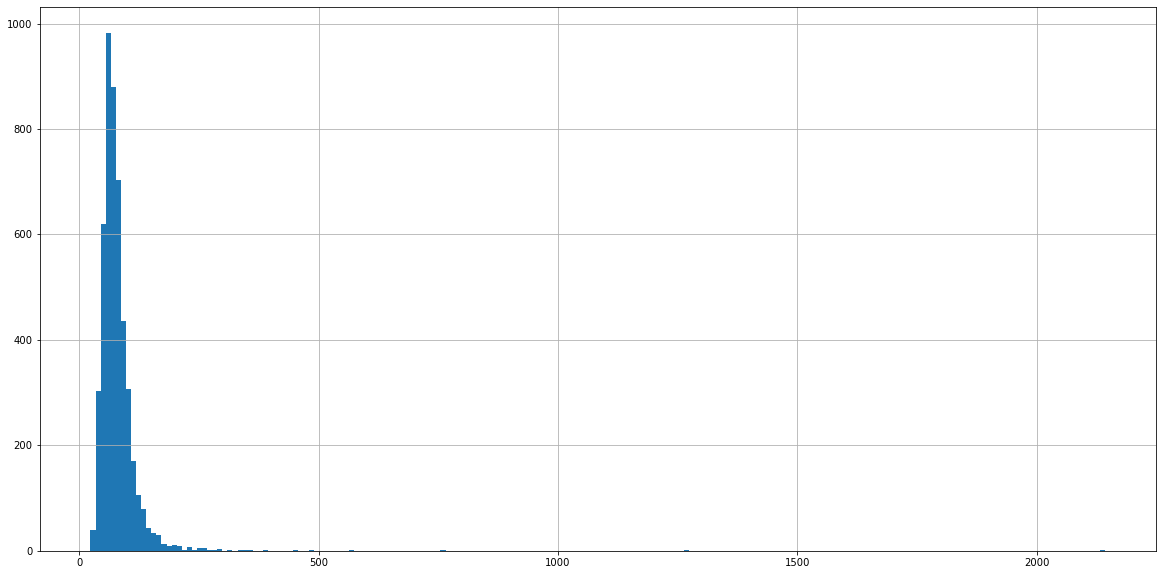

In [14]:
plt.figure(figsize=(20, 10))
plt.hist(diffs, bins=200)
plt.grid(True)

In [15]:
vocab = np.unique(np.concatenate(corpus_tokens_stem).flatten()).tolist()
print(len(vocab))

16397


In [16]:
dataset = []
for i in range(len(corpus_tokens_stem)):
    dataset.append([' '.join(corpus_tokens_stem[i]), data["category"][i]])
dataset = pd.DataFrame(dataset, columns=["text", "category"])

In [17]:
dataset

,text,category
0,выпуст приключенческ игр компан объяв релиз со...,Индустрия
1,британск студ ран участвова работ приключен мн...,Индустрия
2,компан собира выпуст тактическ ролев игр сетти...,Индустрия
3,вышл игр предсто спуст вод сраз ужасн морск су...,Индустрия
4,директор департамент информацион технолог евге...,Индустрия
...,...,...
4809,объяв анимацион фильм станет доступ август экс...,Видео
4810,далек анонсирова продолжен сер пят част подход...,Видео
4811,представ нов трейлер рекламир особен игр свеж ...,Видео
4812,представ дебютн красн оригинал мультфильм расс...,Видео


### 2. Векторизация текстов (TfIdfVectorizer) 

Разбиваем на тренировочную и тестовую выборку

In [18]:
data_train, data_test = train_test_split(dataset, test_size=0.1)
print(len(data_train), len(data_test))

4332 482


In [19]:
data_train.category.value_counts()

Интересное    1349
Индустрия     1227
Видео          691
Техника        587
Кино           478
Name: category, dtype: int64

Производим векторизацию

In [20]:
vectorizer = TfidfVectorizer(vocabulary=vocab)
vectorizer.fit(dataset)

TfidfVectorizer(vocabulary=['а', 'аа', 'аарон', 'аббатств', 'аббревиатур',
                            'абд', 'абонемент', 'абонент', 'абонентск',
                            'абордаж', 'абордажн', 'абориг', 'абориген',
                            'аборт', 'абрах', 'абсолютн', 'абстрактн', 'абсурд',
                            'абсурдн', 'абубакар', 'ав', 'ава', 'авад',
                            'авангард', 'авангардн', 'аванп', 'аванс',
                            'авантюр', 'авантюрист', 'авар', ...])

In [21]:
data_train_vect = vectorizer.transform(data_train["text"])
data_train_cat = data_train["category"]
data_test_vect = vectorizer.transform(data_test["text"])
data_test_cat = data_test["category"]

### 3.Классификация категорий собственного новостного корпуса с помощью моделей классического машинного обучения.

Наивный байесовский классификатор

In [34]:
parameters_nb = {
    "alpha": [0.00001, 0.0001, 0.01, 1, 10] 
}

gs_nb = GridSearchCV(
    MultinomialNB(),
    parameters_nb,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_nb_res = gs_nb.fit(data_train_vect, data_train_cat)
pred_nb = gs_nb_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_nb))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
              precision    recall  f1-score   support

       Видео       0.87      0.91      0.89        75
   Индустрия       0.76      0.75      0.76       122
  Интересное       0.80      0.72      0.76       152
        Кино       0.73      0.81      0.77        53
     Техника       0.79      0.85      0.82        80

    accuracy                           0.79       482
   macro avg       0.79      0.81      0.80       482
weighted avg       0.79      0.79      0.79       482



KNN (K Ближайших Соседей)

In [49]:
parameters_knn = { 
    "n_neighbors": [2, 5, 10, 15, 30, 50, 100],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan"]
}

gs_knn = GridSearchCV( 
    KNeighborsClassifier(),
    parameters_knn,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_knn_res = gs_knn.fit(data_train_vect, data_train_cat) 
pred_knn = gs_knn_res.best_estimator_.predict(data_test_vect) 
print(metrics.classification_report(data_test_cat, pred_knn)) 

Fitting 3 folds for each of 28 candidates, totalling 84 fits
              precision    recall  f1-score   support

       Видео       0.88      0.97      0.92        75
   Индустрия       0.71      0.70      0.71       122
  Интересное       0.73      0.78      0.76       152
        Кино       0.81      0.79      0.80        53
     Техника       0.89      0.71      0.79        80

    accuracy                           0.78       482
   macro avg       0.80      0.79      0.80       482
weighted avg       0.79      0.78      0.78       482



SGD (Стохастический Градиентный Спуск)

In [50]:
parameters_sgd = {
    "penalty": ["elasticnet", "l2", "l1"],
    "alpha": [0.0001, 0.01, 0.1, 0.5, 1, 10,50],
    "max_iter": [100, 500, 1000, 2000],
    "learning_rate": ["optimal", "invscaling", "adaptive"],
    "eta0": [1, 10]
}

gs_sgd = GridSearchCV(
    SGDClassifier(),
    parameters_sgd,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_sgd_res = gs_sgd.fit(data_train_vect, data_train_cat)
pred_sgd = gs_sgd_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_sgd))

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
              precision    recall  f1-score   support

       Видео       0.80      0.88      0.84        75
   Индустрия       0.78      0.80      0.79       122
  Интересное       0.86      0.80      0.83       152
        Кино       0.80      0.85      0.83        53
     Техника       0.88      0.86      0.87        80

    accuracy                           0.83       482
   macro avg       0.83      0.84      0.83       482
weighted avg       0.83      0.83      0.83       482



Логистическая регрессия

In [51]:
parameters_log = {
    "penalty": ["l1"],
    "C": np.logspace(-4, 4, 10,30),
    "solver": ["saga"],
    "max_iter": [500]
}

gs_log = GridSearchCV(
    LogisticRegression(),
    parameters_log,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_log_res = gs_log.fit(data_train_vect, data_train_cat)
pred_log = gs_log_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_log))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

       Видео       0.83      0.97      0.90        75
   Индустрия       0.75      0.77      0.76       122
  Интересное       0.82      0.77      0.79       152
        Кино       0.80      0.81      0.80        53
     Техника       0.89      0.79      0.83        80

    accuracy                           0.81       482
   macro avg       0.82      0.82      0.82       482
weighted avg       0.81      0.81      0.81       482



D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Случайный лес

In [52]:
parameters_forest = {
    "n_estimators": [5, 10, 25, 50],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 25, 50],
    "min_samples_split": [2, 5, 10],
    "max_features": [None, "sqrt"]
}

gs_forest = GridSearchCV(
    RandomForestClassifier(),
    parameters_forest,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_forest_res = gs_forest.fit(data_train_vect, data_train_cat)
pred_forest = gs_forest_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_forest))

Fitting 3 folds for each of 192 candidates, totalling 576 fits
              precision    recall  f1-score   support

       Видео       0.87      0.96      0.91        75
   Индустрия       0.69      0.78      0.73       122
  Интересное       0.77      0.72      0.75       152
        Кино       0.80      0.81      0.80        53
     Техника       0.89      0.74      0.81        80

    accuracy                           0.79       482
   macro avg       0.81      0.80      0.80       482
weighted avg       0.79      0.79      0.79       482



SVC (Метод Опорных Векторов)

In [53]:
parameters_svc = {
    "C":  [1, 10, 100, 1000],
    "gamma": [0.001, 0.0001, "scale"],
    "kernel": ["rbf", "linear", "poly"]
}

gs_svc = GridSearchCV(
    SVC(),
    parameters_svc,
    verbose = 1,
    cv=3,
    n_jobs=-1
)

gs_svc_res = gs_svc.fit(data_train_vect, data_train_cat)
pred_svc = gs_svc_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_svc))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
              precision    recall  f1-score   support

       Видео       0.90      0.97      0.94        75
   Индустрия       0.78      0.82      0.80       122
  Интересное       0.84      0.80      0.82       152
        Кино       0.88      0.85      0.87        53
     Техника       0.91      0.86      0.88        80

    accuracy                           0.85       482
   macro avg       0.86      0.86      0.86       482
weighted avg       0.85      0.85      0.85       482



### 4. Анализ полученных результатов. Сравнение метрики качества, визуализация, выводы.

In [54]:
data_test["category"].value_counts()

Интересное    152
Индустрия     122
Техника        80
Видео          75
Кино           53
Name: category, dtype: int64

In [55]:
models = [gs_knn_res, gs_sgd_res, gs_log_res, gs_forest_res, gs_nb_res, gs_svc_res]
names = ["KNN", "SGD", "Лог. регрессия", "Случайный лес", "Naive Bayes", "SVC"]
preds = [pred_knn, pred_sgd, pred_log, pred_forest, pred_nb, pred_svc]
labels = sorted(dataset["category"].unique())

Выводим лучшие параметры

In [56]:
for name, model in zip(names, models):
    print(name, model.best_params_)

KNN {'metric': 'minkowski', 'n_neighbors': 30, 'weights': 'distance'}
SGD {'alpha': 0.0001, 'eta0': 10, 'learning_rate': 'invscaling', 'max_iter': 500, 'penalty': 'l2'}
Лог. регрессия {'C': 10000.0, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
Случайный лес {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}
Naive Bayes {'alpha': 0.01}
SVC {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Визуализация

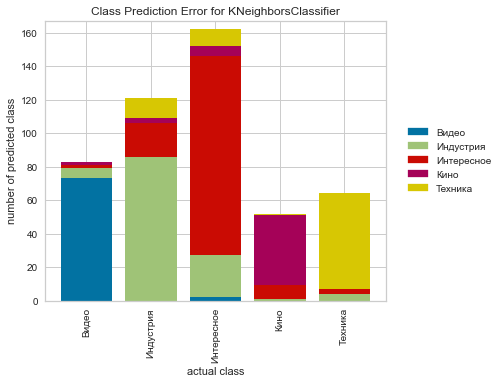

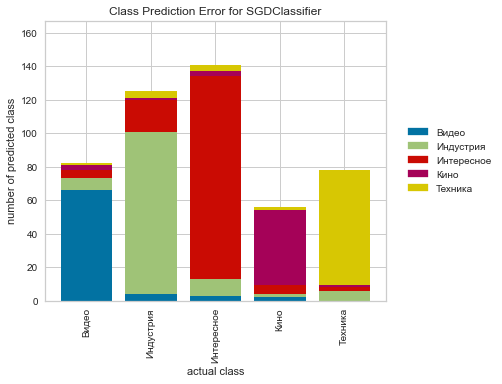

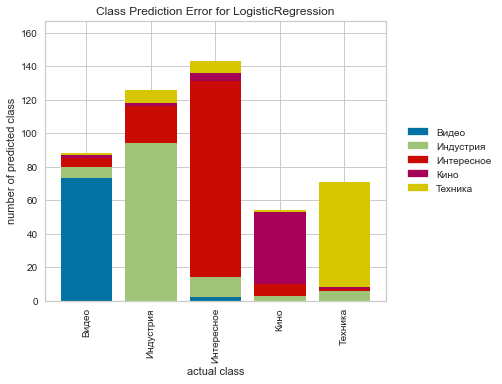

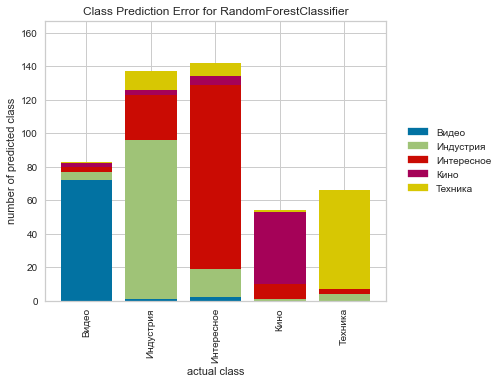

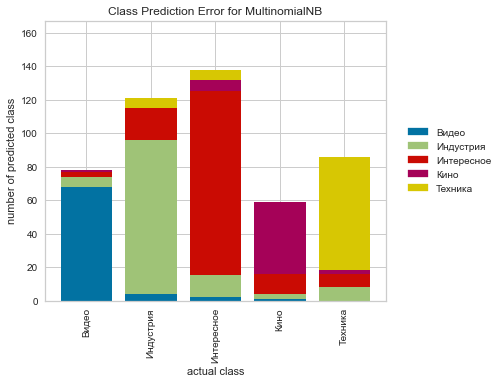

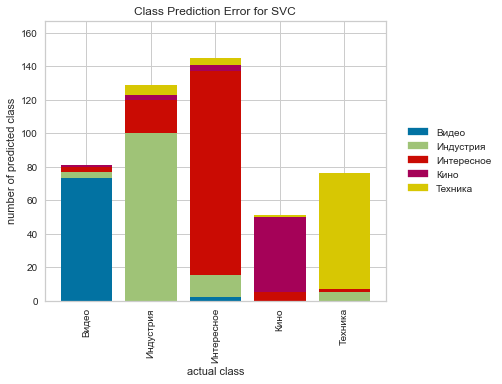

In [61]:
for model in models:
    model.best_estimator_.class_counts_ = 4
    visualizer = ClassPredictionError(
         model.best_estimator_, classes=labels, is_fitted=True
    )
    visualizer.score(data_test_vect, data_test_cat)
    visualizer.show()

Model: KNN


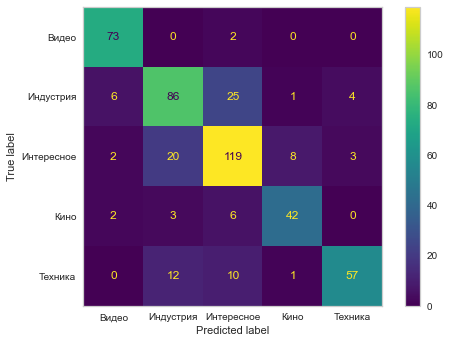

Model: SGD


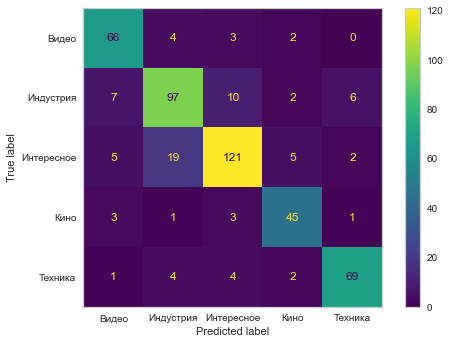

Model: Лог. регрессия


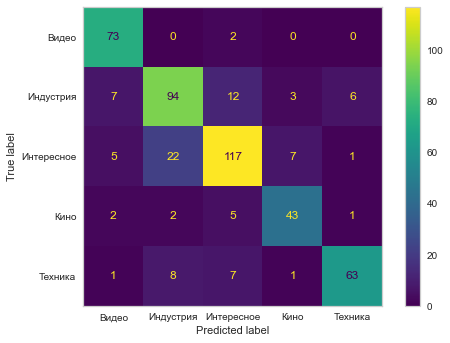

Model: Случайный лес


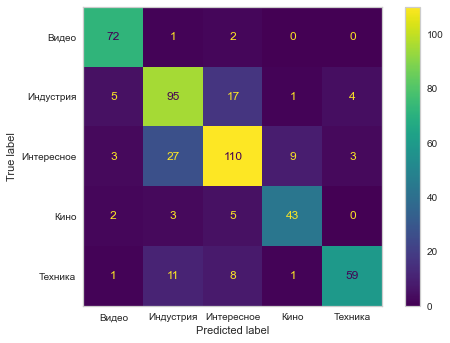

Model: Naive Bayes


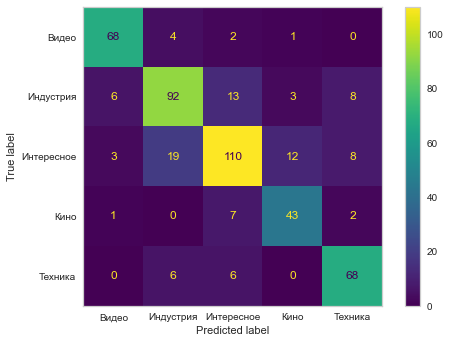

Model: SVC


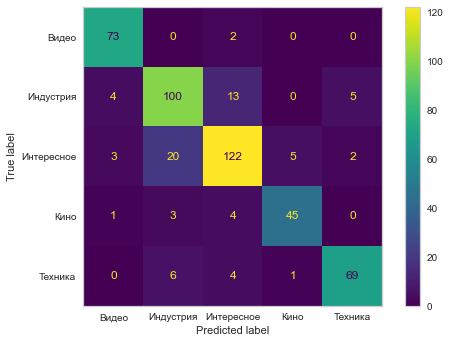

In [62]:
for name, pred in zip(names, preds):
    print(f"Model: {name}")
    metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(data_test_cat, pred),
                                   display_labels = labels).plot()
    plt.grid(False)
    plt.show()

Сравнение по accuracy

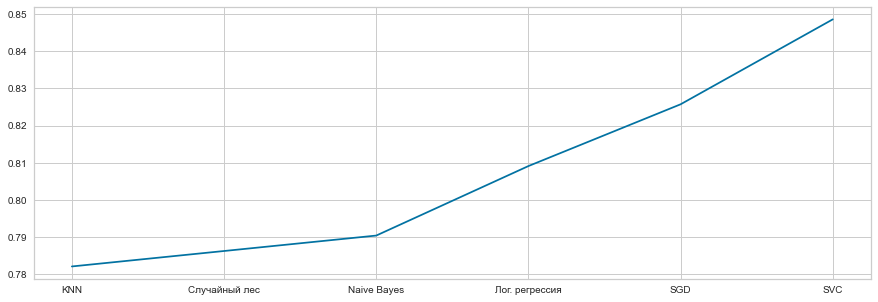

In [63]:
plt.figure(figsize=(15, 5))

acc, names_acc = zip(*sorted(zip([metrics.accuracy_score(data_test_cat, pred) for pred in preds], names)))

plt.grid(True)
plt.plot(names_acc, acc)

Сравнение по F1 мере

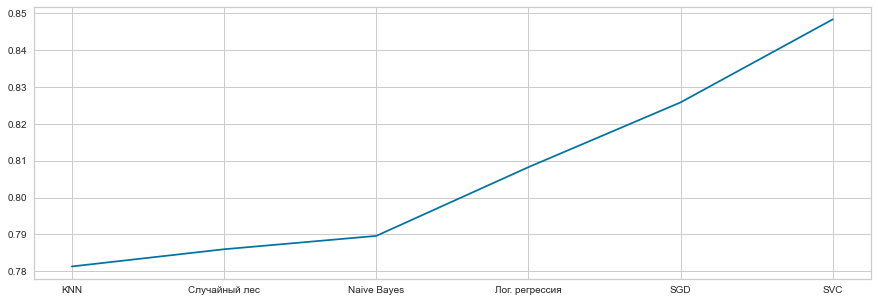

In [64]:
plt.figure(figsize=(15, 5))

f1s, names_f1 = zip(*sorted(zip([metrics.f1_score(data_test_cat, pred, average="weighted") for pred in preds], names)))

plt.grid(True)
plt.plot(names_f1, f1s)

Графики оказались достаточно похожи между собой, по ним можно увидеть лучшие показатели у SVC, потом идут SGD и Лог. регрессия. Хуже всего у Naive Bayes, Случайного леса и KNN

## Итоги

Стоит отметить, что ни одна из моделей идеально не предсказала категории. В большей степени это связано с тем, что данные мы брали с сайта, где иногда у определенных статей было несколько категорий сразу. Что конечно могло повлиять на наш результат. Но с другой стороны, если учитывать это, то результаты достаточно неплохие. 

1. KNN: Эта модель показала больше всех ошибок по сравнению с остальными моделями в предсказании классов. Но её плюс в том, что она быстрее училась. Думаю, если бы не наши условия, то возможно она бы могла претендовать на давольно неплохие результаты. Но не в нашем случае.
2. Случайный лес: Показал результаты уже получше. Но были еще далеки от хорошего результата. Обучение данной модели заняло достаточно много времени, как и в подборе параметров, так и в работе в целом. Так же были ошибки в предсказании.
3. Наивный байесовский классификатор: Был немного лучше предыдущих двух моделей, но не во всех категориях. Так же как и KNN он работал достаточно быстро. Ошибок в предсказании было уже меньше.
4. Логистическая регрессия: Эта модель была одной из самых долгих по обучению. Ей требовалось большое колличество времени. Наверное я даже могу сказать, что она и была самой долгой как и в подборе параметров, так и в обучении. Но при этом не показала лучших результатов из всех моделей.
5. SGD: Здесь были результаты уже лучше. Ошибки в предсказаниях конечно были, но меньше, если сравнивать с другими моделями. Но по времени так же было достаточное долгое обучение.
6. SVC: Была лучшей моделью, которая показала хорошие результаты по сравнению с другими моделями во многих кретериях. Здесь конечно, как и у других моделей были ошибки, но опять же это связано с причинами выше. Но их было меньше всего именно у этой модели. Плюсом хочется отменить не такое большое время обучения, что не может не радовать. 

Конечно не все модели были идеальными и у каждой из них были свои плюсы и минусы. Но конкретно с нашими данными лучше всего показала себя модель SVC.